### data normalization   


In [ ]:
import os  
import numpy as np 
from glob import glob 
import rasterio as rio  
from notebooks import config  
import matplotlib.pyplot as plt  


In [3]:
### secene and truth pairwise data
paths_truth = sorted(glob('data/dset/truth/*.tif'))
paths_scene = [path.replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') for path in paths_truth]
paths_scene[0] 


'data/dset/scene/l5_scene_01.tif'

In [ ]:
def normalize_scene(image, max_bands, min_bands):
    '''
    des: normalize each band of the image to [0, 1]
    args:
        image: H*W*C, numpy array
        max_bands: list of max values for each band (or single value for all bands)
        min_bands: list of min values for each band (or single value for all bands)
    '''
    if isinstance(max_bands, (int, float)):
        max_bands = [max_bands] * image.shape[-1]  
    if isinstance(min_bands, (int, float)):
        min_bands = [min_bands] * image.shape[-1]         
    ## normalization
    min_bands_arr = np.array(min_bands).reshape(1, 1, -1)
    max_bands_arr = np.array(max_bands).reshape(1, 1, -1)
    normalized = (image.astype(float) - min_bands_arr) \
                     / (max_bands_arr - min_bands_arr + 1e-6)
    return np.clip(normalized, 0.0, 1.0)  


#### (1) normalization for satellite image

In [ ]:
for path_scene in paths_scene:
    path_save = path_scene.replace('.tif', '_nor.tif')
    scene_sat = path_scene.split('/')[-1].split('_')[0]
    scene_rio = rio.open(path_scene)
    profile = scene_rio.profile.copy()
    profile.update(dtype='float32') 
    scene_nor = normalize_scene(image=scene_rio.read(), 
                                max_bands=config.max_scenes[scene_sat], 
                                min_bands=config.min_scenes[scene_sat])
    # write to disk
    if os.path.exists(path_save): os.remove(path_save)
    with rio.open(path_save, 'w', **profile) as dst:
        dst.write(scene_nor.astype('float32'))
    print(f'Wrote normalized scene to: {path_save}')
    break 


Wrote normalized scene to: data/dset/scene/l5_scene_01_nor.tif


#### (2) normalization for dem

In [9]:
for path_dem in paths_dem:
    path_save = path_dem.replace('.tif', '_nor.tif')
    dem_rio = rio.open(path_dem)
    profile = dem_rio.profile.copy()
    profile.update(dtype='float32') 
    dem_nor = normalize_scene(image=dem_rio.read(), 
                                max_bands=config.max_dem, 
                                min_bands=config.min_dem)
    # write to disk
    if os.path.exists(path_save): os.remove(path_save)
    with rio.open(path_save, 'w', **profile) as dst:
        dst.write(dem_nor.astype('float32'))
    print(f'Wrote normalized scene to: {path_save}')
    break 


Wrote normalized scene to: data/dset/dem/l5_scene_01_dem_nor.tif


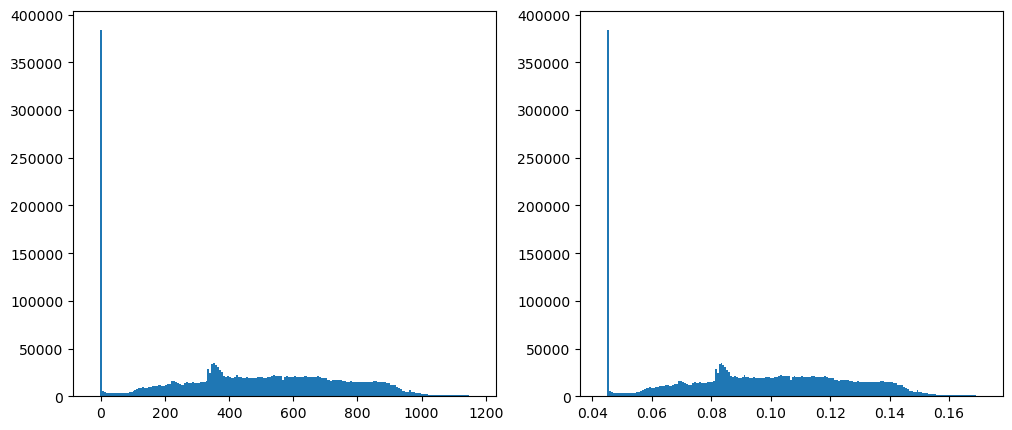

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
id_scene = 2
img_rio = rio.open(paths_dem[id_scene])
img_nor_rio = rio.open(paths_dem[id_scene].replace('.tif', '_nor.tif'))
ax[0].hist(img_rio.read().flatten(), bins=200)
ax[1].hist(img_nor_rio.read().flatten(), bins=200);  
